In [1]:
# データ分析・操作用ライブラリ
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

# NLP用ライブラリ
import MeCab,re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec

# スコア評価用ライブラリ
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support

# モデルの読み込み、保存
from sklearn.externals import joblib

# エラー表示の抑制
import warnings

D:\Program\Anaconda3\envs\sklearn1.9.1\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# 表示関連
# DataFrameの列数設定
pd.set_option('display.max_columns', 500)
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')

In [3]:
def tokenize(text):
    tokens = []
    tagger = MeCab.Tagger()
    node = tagger.parseToNode(text)
    while node:
        if node.feature.split(",")[0] in ['名詞'] :
                replace_node = re.sub( re.compile( "[!-/:-@[-`{-~]" ), "", node.surface )
                if replace_node != "" and replace_node != " ":
                    tokens.append(replace_node)
        node = node.next
    return tokens

In [4]:
def MeanEmbeddingVectorizer(arr, model):
    mean_vectors = []
    for document in arr:
        tokens = tokenize(document)
        vectors = [model.get_vector(token) for token in tokens if token in model.vocab]
        if vectors:
            mean_vec = np.vstack(vectors).mean(axis=0)
            mean_vectors.append(mean_vec)
        else:
            mean_vectors.append(np.zeros(100))
        embedding = np.vstack(mean_vectors)        
    return embedding

In [5]:
# テキストデータの読み込み
wikiData = pd.read_csv("csv/train_cleaned.csv", encoding="utf-8")

# 読み込みデータの表示
wikiData.head()

,text,target
0,ドール・フード・カンパニー ドール・フード・カンパニー Dole Food Comp...,1
1,南ヶ丘牧場 株式会社 南ヶ丘牧場 みなみ じょう 栃木県 那須高原 本拠 酪...,1
2,岩瀬牧場 岩瀬牧場 ぼくじょう 日本 福島県 岩瀬 郡 鏡石町 牧場 鏡石...,1
3,くら ぎ GI Co Ltd 三重県 中心 農業 店舗 展開 会社 本...,1
4,ハッピーネモファーム 株式会社 ハッピーネモファーム 北海道 浦河 郡 浦河町 ...,1


In [6]:
# Numpy配列へ変換
X = wikiData.text.values
y = wikiData.target.values

In [7]:
# トレーニングデータ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# 分散表現の読み込み
import gensim.models.keyedvectors as word2vec_for_txt
model_dir = 'model/fastText.model.vec'
model = word2vec_for_txt.KeyedVectors.load_word2vec_format(model_dir, binary=False)

In [9]:
# 分散表現へ変換
X_train = MeanEmbeddingVectorizer(X_train, model)
X_test = MeanEmbeddingVectorizer(X_test, model)

In [10]:
# Light GBM
import lightgbm as lgb

clf = lgb.LGBMClassifier(objective='multiclass', num_class=33)
clf.fit(X_train, y_train)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)

print("Training score：" + str(clf.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf.score(X_test, y_test)))

Training score：0.999890877346
Cross-Validation score：0.699515856083
Test score：0.692274116107


In [11]:
# 学習結果の保存
joblib.dump(clf, 'model/lgbm_fastText.pkl')

['model/lgbm_fastText.pkl']

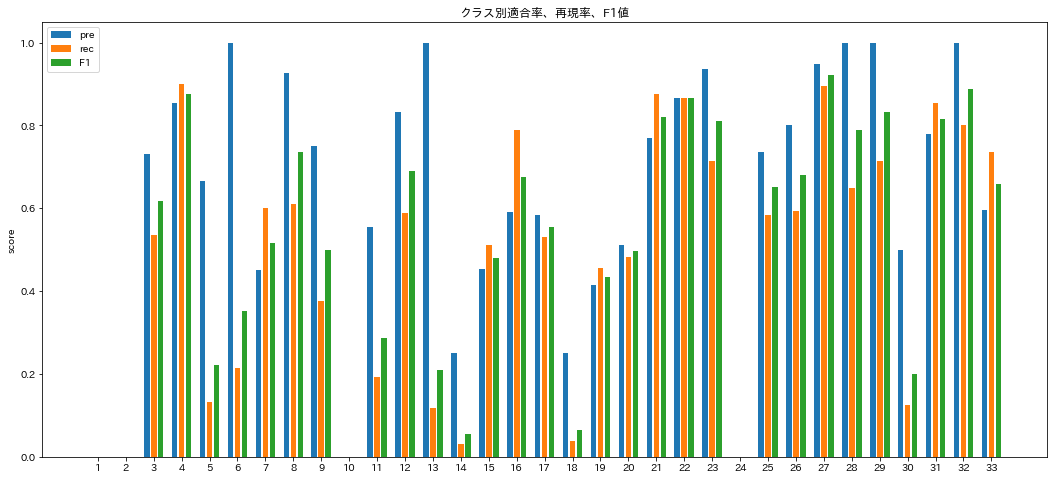

In [12]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)
wiki_gpby = wikiData.groupby('target').count()
y = wiki_gpby['text'].values
x =wiki_gpby.index.values

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [28]:
# ロジスティック回帰
from sklearn.linear_model import LogisticRegression

## multinomial
clf2 = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', random_state=42)
clf2.fit(X_train, y_train)
cv_scores = cross_val_score(clf2, X_train, y_train, cv=5)

print("Training score：" + str(clf2.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf2.score(X_test, y_test)))
                          
## One-versus-the-rest
clf3 = LogisticRegression(solver='liblinear', multi_class = 'ovr', random_state=42)
clf3.fit(X_train, y_train)
cv_scores = cross_val_score(clf3, X_train, y_train, cv=5)

print("Training score：" + str(clf3.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf3.score(X_test, y_test)))

Training score：0.762221737233
Cross-Validation score：0.726550542839
Test score：0.714098646879
Training score：0.739633347883
Cross-Validation score：0.713777995434
Test score：0.704932343955


In [29]:
# 学習結果の保存
joblib.dump(clf2, 'model/lr_mul_fastText.pkl')
joblib.dump(clf3, 'model/lr_ovr_fastText.pkl')

['model/lr_ovr_fastText.pkl']

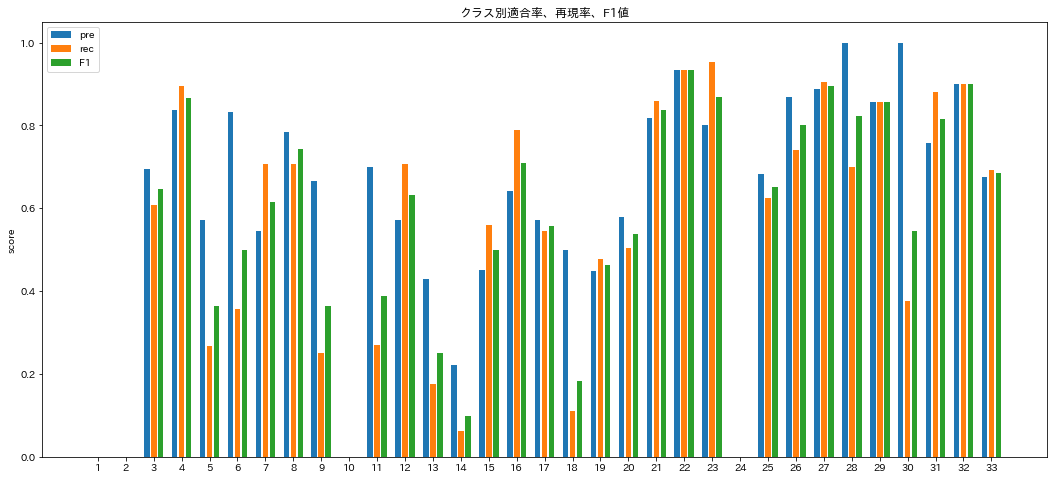

In [14]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf2.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

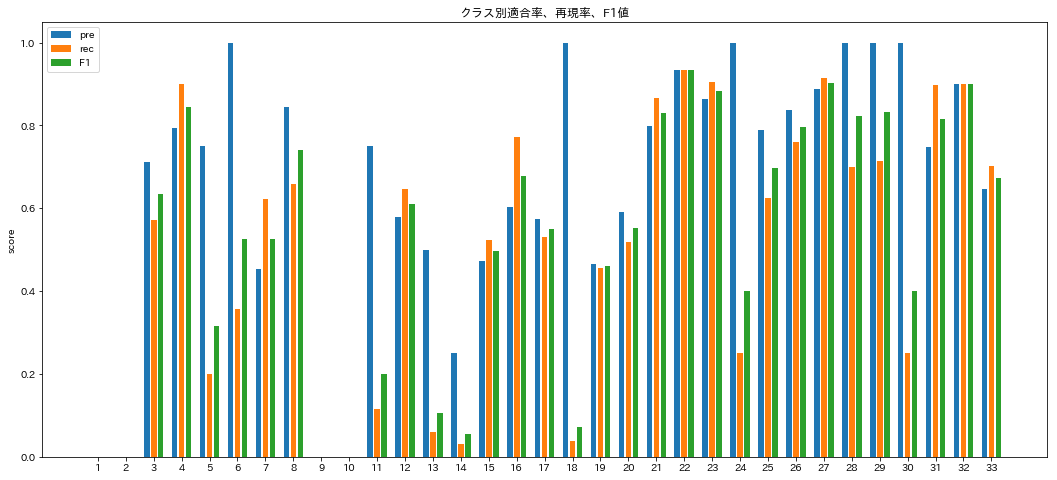

In [15]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf3.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [16]:
# SVM
from sklearn.svm import SVC

## パラメーター設定
kernel = 'rbf'

## One-versus-the-rest
clf4 = SVC(kernel=kernel, decision_function_shape='ovr', random_state=42)
clf4.fit(X_train, y_train)
cv_scores = cross_val_score(clf4, X_train, y_train, cv=5)

print("Training score：" + str(clf4.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf4.score(X_test, y_test)))
                          

## One-versus-the-one(multi-class default)
clf5 = SVC(kernel=kernel,  decision_function_shape='ovo', random_state=42)
clf5.fit(X_train, y_train)
cv_scores = cross_val_score(clf5, X_train, y_train, cv=5)

print("Training score：" + str(clf5.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf5.score(X_test, y_test)))

Training score：0.61752509821
Cross-Validation score：0.591349495157
Test score：0.594936708861
Training score：0.61752509821
Cross-Validation score：0.591349495157
Test score：0.594936708861


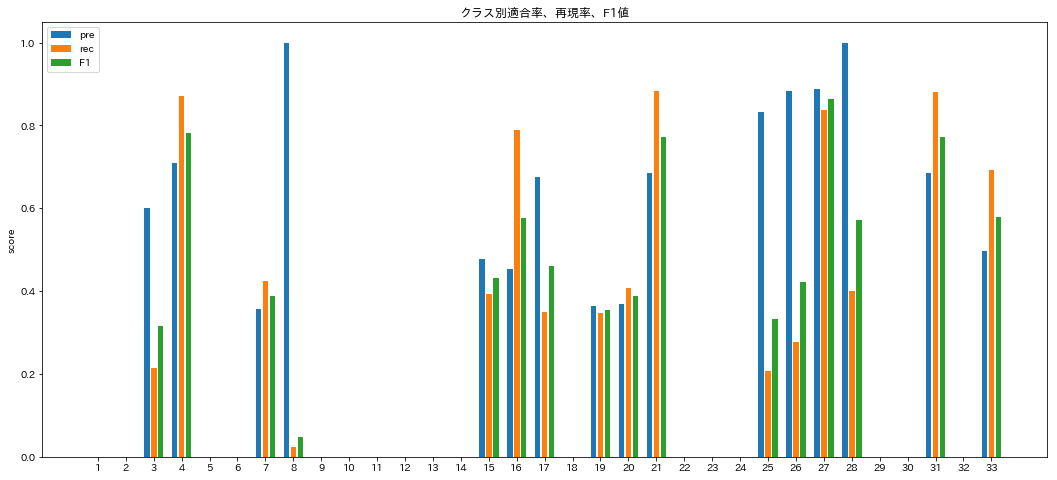

In [17]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf4.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

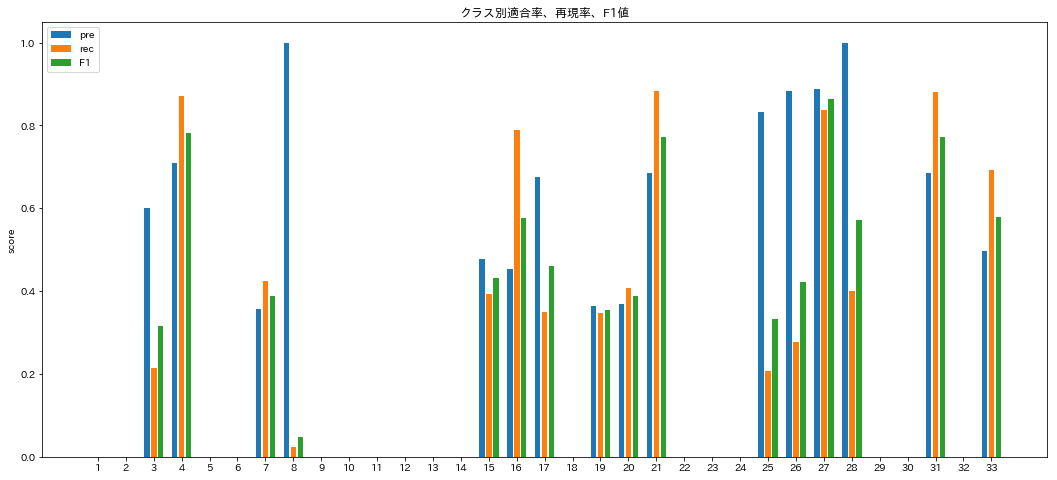

In [18]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf5.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

In [23]:
# SVC(Liner)

## パラメーター設定
kernel = 'linear'

## One-versus-the-rest(multi-class default)
clf6 =  SVC(kernel=kernel, decision_function_shape='ovr', probability = True, random_state=42)
clf6.fit(X_train, y_train)
cv_scores = cross_val_score(clf6, X_train, y_train, cv=5)

print("Training score：" + str(clf6.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf6.score(X_test, y_test)))
                          

## crammer_singer
clf7 = SVC(kernel=kernel,  decision_function_shape='ovo', probability = True ,random_state=42)
clf7.fit(X_train, y_train)
cv_scores = cross_val_score(clf7, X_train, y_train, cv=5)

print("Training score：" + str(clf7.score(X_train, y_train)))
print("Cross-Validation score：" + str(np.mean(cv_scores)))
print("Test score：" + str(clf7.score(X_test, y_test)))

Training score：0.792448712353
Cross-Validation score：0.741262884185
Test score：0.731994762113
Training score：0.792448712353
Cross-Validation score：0.741262884185
Test score：0.731994762113


In [24]:
# 学習結果の保存
joblib.dump(clf6, 'model/lsvc_ovr_fastText.pkl')
joblib.dump(clf7, 'model/lsvc_ovo_fastText.pkl')

['model/lsvc_ovo_fastText.pkl']

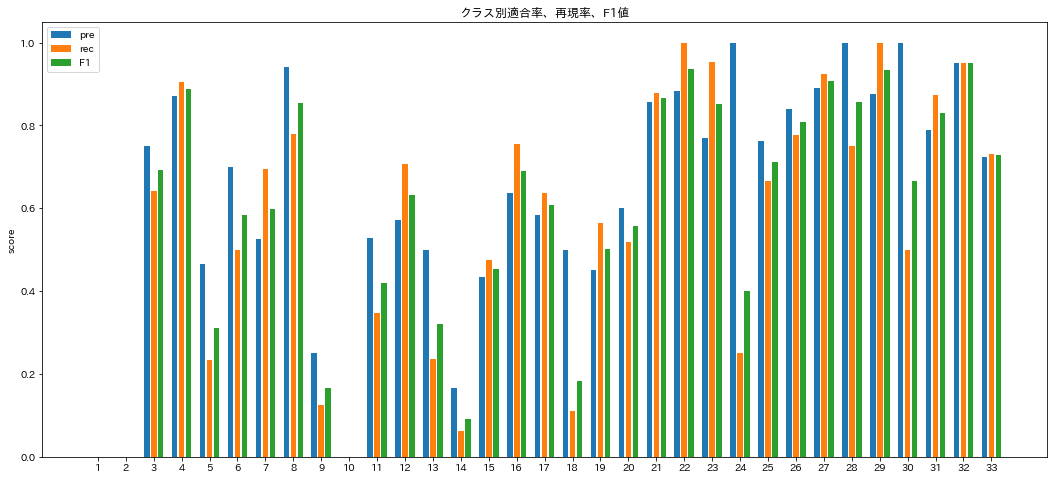

In [21]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf6.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()

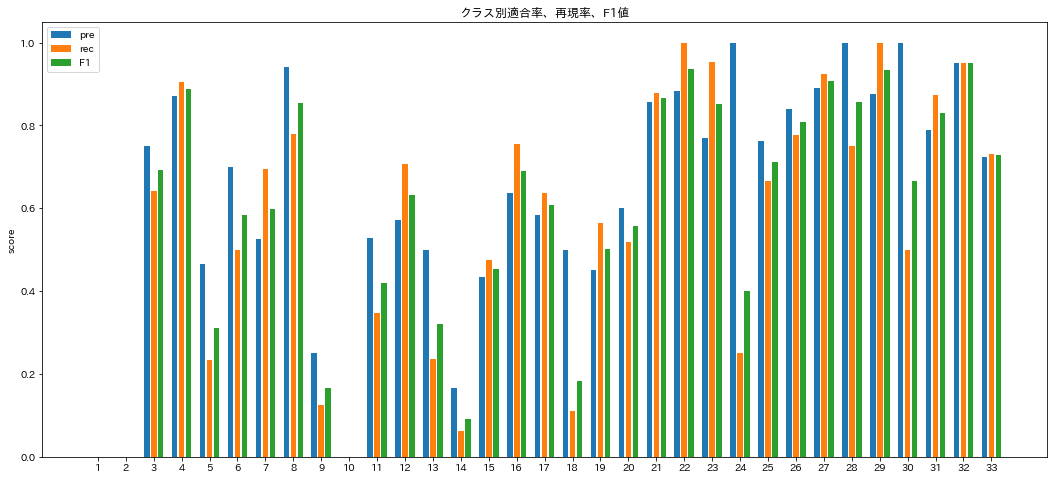

In [22]:
# テストスコアのクラス別適合率、再現率、F1値を計算
pred_test = clf7.predict(X_test)
p_r_f = precision_recall_fscore_support(y_test, pred_test)

# クラス別適合率、再現率、F1値を表示
plt.figure(figsize=(18, 8))
plt.title("クラス別適合率、再現率、F1値")
plt.ylabel("score")
plt.xticks(x)
plt.bar(x-0.25, p_r_f[0], width=0.2, label='pre')
plt.bar(x, p_r_f[1], width=0.2, label='rec')
plt.bar(x+0.25, p_r_f[2], width=0.2, label='F1')
plt.legend(loc=2)    
plt.show()